In [1]:
# Required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler, QuantileTransformer, PowerTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

from catboost import CatBoostClassifier

# Set options
pd.set_option('display.max_column', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')

df_train.sample(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
12089,12089,C,93.33,material_7,material_8,5,8,12,10,2,19.009,11.574,NaN,19.109,12.000,21.015,11.419,16.581,20.553,11.270,16.828,14.721,14.393,16.032,965.584,0
450,450,A,76.63,material_7,material_8,9,5,11,0,2,18.681,12.723,17.553,16.123,11.476,21.262,11.201,18.975,18.307,13.122,14.297,14.980,13.167,14.891,870.866,0
4858,4858,A,106.56,material_7,material_8,9,5,17,2,9,19.033,11.163,15.774,17.081,12.766,18.597,NaN,16.904,18.225,NaN,15.846,16.470,15.700,18.275,593.613,0


In [3]:
# Drop the id columns
dropped_columns = ['id', 'product_code']

df_train_model = df_train.drop(dropped_columns, axis=1)
df_test_model = df_test.drop(dropped_columns, axis=1)

# Assign train and test for X and y
X_train = df_train_model.drop('failure', axis=1)
y_train = df_train_model['failure']

X_test = df_test_model.copy()

In [4]:
cat_features = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
continous_features = [cat for cat in X_train.columns if cat not in cat_features]

In [5]:
def create_missingness_features(source_df, target_df, features):
    """
    Create different types of features based on the presence of holes
    (missing data) in the source_df
    """
    target_df = target_df.to_frame()
    target_df["no_null"] = source_df.loc[:, features].isna().sum(axis=1)
    target_df["null_mean"] = source_df[features].isna().mean(axis=1)
    target_df["null_std"] = source_df[features].isna().std(axis=1)
    target_df["null_var"] = source_df[features].isna().var(axis=1)
    target_df["null_skew"] = source_df[features].isna().skew(axis=1)
    target_df["null_kurt"] = source_df[features].isna().kurt(axis=1)
    target_df["null_sem"] = source_df[features].isna().sem(axis=1)

    # Frequency mapping for the number of nulls per row
    freq_map_dict = source_df.isna().sum(axis=1).value_counts(dropna=False)
    target_df["null_sum_freq"] = (
        source_df.isna().sum(axis=1).map(freq_map_dict).astype(np.int32)
    )

    return target_df

In [6]:
def catboost_kfold_feature_importance(X_train, y_train, cat_features=None, n_splits=5, random_state=5):
    """
    Perform K-Fold cross-validation with CatBoost and calculate feature importances.

    Args:
    - X_train: DataFrame, training features.
    - y_train: Series, training target.
    - cat_features: List of categorical feature names (default is None).
    - n_splits: Number of K-Fold splits (default is 5).
    - random_state: Random seed for reproducibility (default is 5).

    Returns:
    - fi_df: DataFrame, feature importances with fold-wise and average values.
    """

    # Initialize DataFrame to store feature importances
    fi_df = pd.DataFrame({'Feature': X_train.columns})

    # Initialize K-Fold cross-validator
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Create empty array to store fold AUC scores
    fold_scores = np.zeros(n_splits)

    # Initialize CatBoost model
    model = CatBoostClassifier(random_state=random_state, cat_features=cat_features, verbose=False)

    # Perform K-Fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the CatBoost model
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=100)

        # Calculate fold AUC score
        y_pred_val = model.predict_proba(X_val)[:, 1]
        fold_score = roc_auc_score(y_val, y_pred_val)
        fold_scores[fold] = fold_score

        # Record feature importances for this fold
        feature_importance = model.get_feature_importance()
        fi_df[f'Fold_{fold + 1}'] = feature_importance

    # Calculate and append average feature importance
    fi_df['Average'] = fi_df.iloc[:, 1:].mean(axis=1)

    fi_df.to_csv('feature_importance.csv', index=False)

    return fi_df


In [7]:
def plot_catboost_feature_importance(X_train, y_train, cat_features):
    fi_df = catboost_kfold_feature_importance(X_train, y_train, cat_features=cat_features)
    fi_df.sort_values(by='Average', ascending=False, inplace=True)

    plt.figure(figsize=(16, 12))
    sns.barplot(
        x=fi_df['Average'],
        y=fi_df['Feature'],
    )

    plt.title('Features (avg over folds)')
    plt.show()

In [8]:
target = 'failure'

target_df = create_missingness_features(X_train, y_train, continous_features)
null_fe_df = pd.concat([X_train, target_df.drop(target, axis=1)], axis=1)
null_fe_df.head()

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,no_null,null_mean,null_std,null_var,null_skew,null_kurt,null_sem,null_sum_freq
0,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,1,0.052632,0.229416,0.052632,4.358899,19.0,0.052632,9680
1,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,12183
2,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,1,0.052632,0.229416,0.052632,4.358899,19.0,0.052632,9680
3,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,12183
4,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,12183


Learning rate set to 0.067421
0:	learn: 0.6676024	test: 0.6677380	best: 0.6677380 (0)	total: 85.7ms	remaining: 1m 25s
100:	learn: 0.4930249	test: 0.5112911	best: 0.5108786 (55)	total: 2.54s	remaining: 22.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5108785644
bestIteration = 55

Shrink model to first 56 iterations.
Learning rate set to 0.067421
0:	learn: 0.6677111	test: 0.6679321	best: 0.6679321 (0)	total: 35.9ms	remaining: 35.9s
100:	learn: 0.4932796	test: 0.5088780	best: 0.5086568 (62)	total: 2.45s	remaining: 21.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5086567974
bestIteration = 62

Shrink model to first 63 iterations.
Learning rate set to 0.067421
0:	learn: 0.6677009	test: 0.6678327	best: 0.6678327 (0)	total: 26.8ms	remaining: 26.8s
100:	learn: 0.4924504	test: 0.5120920	best: 0.5113094 (56)	total: 2.44s	remaining: 21.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5113093543
bestIteration = 56

Shrink 

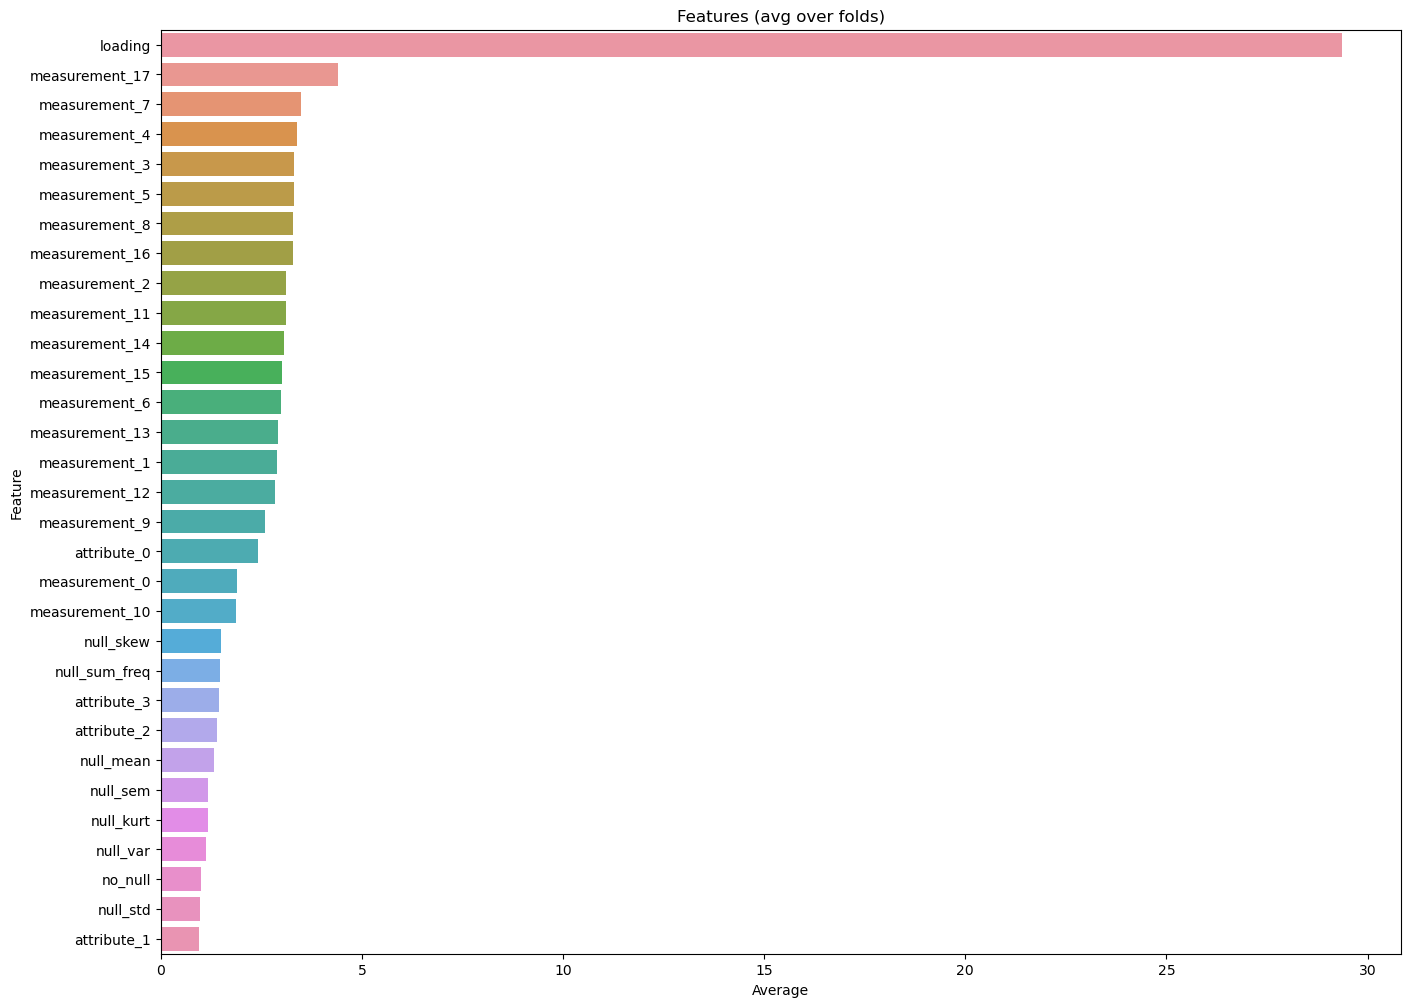

In [9]:
plot_catboost_feature_importance(null_fe_df, y_train, cat_features)

In [10]:
# Based on the feature importance figure, decide which features to possibly drop
dropped_columns_low_fi = ['attribute_1','attribute_2', 'attribute_3']

In [11]:
# Initialize CatBoost model
# model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1','attribute_2', 'attribute_3'], verbose=False)
model = CatBoostClassifier(random_state=5, cat_features=['attribute_0'], verbose=False)

num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=5)

scores = cross_val_score(model, X_train.drop(dropped_columns_low_fi, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')

list(scores), scores.mean()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


([0.5632922845414631,
  0.5644477909947714,
  0.556887172371783,
  0.5698387451564325,
  0.5567716881842332],
 0.5622475362497366)

In [12]:
# Fit the model on the entire training data
model.fit(X_train.drop(dropped_columns_low_fi, axis=1), y_train)

# Predict on the X_test data
predictions = model.predict_proba(X_test.drop(dropped_columns_low_fi, axis=1))[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame(
    {'id': df_test['id'],
    'failure': predictions})

# submission_df.head(50)
# Save to CSV for submission
submission_df.to_csv('submission.csv', index=False)